# Imports

In [ ]:
%matplotlib inline

import corner
import emcee
import time
import numpy as np
import numpy.testing as test
import matplotlib.pyplot as plt
import model_flux_ratio as mfr

from astropy.table import Table
from matplotlib.ticker import MaxNLocator

# Load generated flux ratios from generate_fake_spectra

In [2]:
flux_ratios = Table.read('/Users/thsyu/Software/Yp/LeoP', format='ascii', delimiter=' ')

In [3]:
flux_ratios

Wavelength,Species,Flux Ratio,Flux Ratio Errors,EW,EW Errors
float64,str15,float64,float64,float64,float64
3890.166,hydrogen+helium,0.175,0.007,16.3,1.6
4027.328,helium,0.011,0.007,1.0,0.1
4102.891,hydrogen,0.246,0.006,26.5,2.7
4341.684,hydrogen,0.431,0.009,54.6,5.5
4472.755,helium,0.033,0.006,4.5,0.5
4862.721,hydrogen,1.0,0.02,183.2,18.3
5017.079,helium,0.026,0.006,5.0,0.5
5877.299,helium,0.103,0.004,30.2,3.0
6564.612,hydrogen,2.949,0.059,1222.0,122.0


# MCMC Attempt

"Real Data": read in the measured flux ratios and their equivalent widths

In [4]:
# Names of wavelenghts of interest for MCMC
y_names = ['HeI+H83890', 'HeI4027', 'Hd', 'Hg', 'HeI4472', 'Hb', 'HeI5017', 'HeI5877', 'Ha', 'HeI6679', 'HeI7067']

# Balmer and Helium lines of interest for MCMC
balmer_lines = np.array([6564.612, 4862.721, 4341.684, 4102.891, 3890.166]) # Ha, Hb, Hg, Hd, H8
helium_lines = np.array([7067.198, 6679.994, 5877.299, 5017.079, 4472.755, 4027.328, 3890.151])

# Wavelengths we care about for MCMC
emis_lines = np.sort(np.concatenate((balmer_lines, helium_lines)))[1:] # [1:] to remove the duplicate ~3890 wavelength

# Measured data from spectra
EWs_meas = np.array(flux_ratios['EW'])
EW_errors = np.array(flux_ratios['EW Errors'])
EW_Hb = flux_ratios['EW'][np.where(flux_ratios['Wavelength'] == 4862.721)[0]]

y = np.array(flux_ratios['Flux Ratio']) # F(lambda) / F(H-beta)
#y_error = np.array(flux_ratios['Flux Ratio'] * 0.002)
y_error = np.array(flux_ratios['Flux Ratio Errors'])
x = np.zeros(y.size)

Determine some range of values for the 8 parameters

In [5]:
# Range of values for 8 parameters: y_plus, temp, dens, c_Hb, a_H, a_He, tau_He, xi/n_HI
min_y_plus, max_y_plus = 0.05, 0.1  # fraction of singly ionized He; y+ = He+/H+
min_temp, max_temp = 14400, 21600 #5000, 25000  # electron temperature (K)
min_log_dens, max_log_dens = 0, 3  # log10(electron density) (cm^-3)
min_c_Hb, max_c_Hb = 0, 0.5  # reddening
min_a_H, max_a_H = 0, 10  # underlying stellar H absorption (Angstroms)
min_a_He, max_a_He = 0, 4  # underlying stellar HeI absorption (Angstroms)
min_tau_He, max_tau_He = 0, 5  # optical depth; range of values from Izotov & Thuan 2010
#min_n_HI, max_n_HI = 1e-4, 1e-1  # neutral hydrogen density (cm^-3)
min_log_xi, max_log_xi = -6, -0.0969 # equals to xi=0-0.8; ratio of neutral hydrogen to singly ionized hydrogen densities; xi = n(HI)/n(HII)

## Maximum Likelihood

In [6]:
# Set up MCMC
def get_model(theta):
#    y_plus, temp, log_dens, c_Hb, a_H, a_He, tau_He, n_HI = theta
    y_plus, temp, log_dens, c_Hb, a_H, a_He, tau_He, log_xi = theta

    # Reparameterize density and neutral hydrogen input
    dens = 10 ** log_dens
    xi = 10 ** log_xi
    #eta = n_HI / dens

    # Take into account errors in EW
    EWs = np.random.normal(EWs_meas, EW_errors)
    # Continuum flux ratio
    h = y * EW_Hb / EWs # relative to H-beta; h(lambda)/h(H-beta)
    # **** Should this be done before or after EWs are perturbed by their errors? ****

    # Model flux
    model_flux = np.zeros(11) # 11 emission line fluxes we want to model

    # Some values, calculated at Hbeta, for later use in model flux
    collisional_to_recomb_Hbeta = mfr.hydrogen_collision_to_recomb(xi, balmer_lines[1], temp)
    f_lambda_at_Hbeta = mfr.f_lambda_avg_interp(balmer_lines[1])

    for w in range(len(emis_lines)):
        # Determine if working with hydrogen or helium line; within 3 Angstroms is arbitrary but should cover difference in vacuum vs air wavelength
        nearest_wave = emis_lines[np.where(np.abs(emis_lines - emis_lines[w]) < 3)[0]][0]
        # The above line is redundant, but allows for cases where emis_lines[w] is some other array, say waves_of_interest[w], 
        # and not exactly at the wavelengths given in the emis_lines array (which is concatenated from arrays balmer_lines and helium_lines)

        # Any Balmer line besides the blended HeI+H8 line (H8 at 3890.166)
        if nearest_wave in balmer_lines and nearest_wave != 3890.166:
            line_species = 'hydrogen'

            emissivity_ratio = mfr.hydrogen_emissivity(emis_lines[w], temp, dens)
            a_H_at_wave = mfr.stellar_absorption(emis_lines[w], a_H, ion=line_species)
            collisional_to_recomb_ratio = mfr.hydrogen_collision_to_recomb(xi, emis_lines[w], temp)
            reddening_function = ( mfr.f_lambda_avg_interp(emis_lines[w]) / f_lambda_at_Hbeta ) - 1.            

#            flux = emissivity_ratio * ( ( (EW_Hb + a_H)/(EW_Hb) ) / ( (EWs[w] + a_H_at_wave)/(EWs[w]) ) ) * \
#                ( (1 + collisional_to_recomb_ratio) / (1 + collisional_to_recomb_Hbeta) ) * \
#                10**-(reddening_function * c_Hb)

            flux = ( emissivity_ratio * ( (1 + collisional_to_recomb_ratio) / (1 + collisional_to_recomb_Hbeta) ) * \
                10**-(reddening_function * c_Hb) * ( (EW_Hb + a_H)/(EW_Hb) ) ) - ( (a_H_at_wave / EW_Hb) * (h[w]) )
                    
        # Any HeI line besides the blended HeI+H8 line (HeI at 3890.151)
        elif nearest_wave in helium_lines and nearest_wave != 3890.151:
            line_species = 'helium'
            
            emissivity_ratio = mfr.helium_emissivity(emis_lines[w], temp, dens)
            a_He_at_wave = mfr.stellar_absorption(emis_lines[w], a_He, ion=line_species)
            optical_depth_at_wave = mfr.optical_depth_function(emis_lines[w], temp, dens, tau_He)
            collisional_to_recomb_ratio = mfr.helium_collision_to_recomb(emis_lines[w], temp, dens)
            reddening_function = ( mfr.f_lambda_avg_interp(emis_lines[w]) / f_lambda_at_Hbeta ) - 1.

#            flux = y_plus * emissivity_ratio * ( ( (EW_Hb + a_H)/(EW_Hb) ) / ( (EWs[w] + a_He_at_wave)/(EWs[w]) ) ) * \
#                optical_depth_at_wave * ( (1 + collisional_to_recomb_ratio) / (1 + collisional_to_recomb_Hbeta) ) * \
#                10**-(reddening_function * c_Hb)
            flux = ( y_plus * emissivity_ratio *  optical_depth_at_wave * ( (1 + collisional_to_recomb_ratio) / (1 + collisional_to_recomb_Hbeta) ) * \
                10**-(reddening_function * c_Hb) * ( (EW_Hb + a_H)/(EW_Hb) ) ) - ( (a_He_at_wave/EW_Hb) * (h[w]) )

        # The blended HeI+H8 line
        elif nearest_wave == 3890.151 or nearest_wave == 3890.166:
            # HeI 3890.151 contribution:
            line_species = 'helium'

            emissivity_ratio = mfr.helium_emissivity(emis_lines[w], temp, dens)
            a_He_at_wave = mfr.stellar_absorption(emis_lines[w], a_He, ion=line_species)            
            optical_depth_at_wave = mfr.optical_depth_function(emis_lines[w], temp, dens, tau_He)            
            collisional_to_recomb_ratio = mfr.helium_collision_to_recomb(emis_lines[w], temp, dens)            
            reddening_function = ( mfr.f_lambda_avg_interp(emis_lines[w]) / f_lambda_at_Hbeta ) - 1.

            flux = ( y_plus * emissivity_ratio *  optical_depth_at_wave * ( (1 + collisional_to_recomb_ratio) / (1 + collisional_to_recomb_Hbeta) ) * \
                10**-(reddening_function * c_Hb) * ( (EW_Hb + a_H)/(EW_Hb) ) ) - ( (a_He_at_wave/EW_Hb) * (h[w]) )
 
            # H8 contribution:
            line_species = 'hydrogen'

            emissivity_ratio = mfr.hydrogen_emissivity(emis_lines[w], temp, dens)
            a_H_at_wave = mfr.stellar_absorption(emis_lines[w], a_H, ion=line_species)            
            collisional_to_recomb_factor = np.exp(( -13.6 * ((1/5**2)-(1/8**2)) ) / (8.6173303e-5 * temp)) # scale factor for going from C/R(Hg) to C/R(H8)
            collisional_to_recomb_ratio = collisional_to_recomb_factor * mfr.hydrogen_collision_to_recomb(xi, 4341.684, temp) # Calculate C/R(Hg) and multiply by above scale factor
            reddening_function = ( mfr.f_lambda_avg_interp(emis_lines[w]) / f_lambda_at_Hbeta ) - 1.            

            flux += ( emissivity_ratio * ( (1 + collisional_to_recomb_ratio) / (1 + collisional_to_recomb_Hbeta) ) * \
                10**-(reddening_function * c_Hb) * ( (EW_Hb + a_H)/(EW_Hb) ) ) - ( (a_H_at_wave / EW_Hb) * (h[w]) )

        model_flux[w] = flux

    return model_flux

In [7]:
# Define the probability function as likelihood * prior.
def lnprior(theta):
#    y_plus, temp, log_dens, c_Hb, a_H, a_He, tau_He, n_HI = theta
    y_plus, temp, log_dens, c_Hb, a_H, a_He, tau_He, log_xi = theta

    if min_y_plus <= y_plus <= max_y_plus and \
        min_temp <= temp <= max_temp and \
        min_log_dens <= log_dens <= max_log_dens and \
        min_c_Hb <= c_Hb <= max_c_Hb and \
        min_a_H <= a_H <= max_a_H and \
        min_a_He <= a_He <= max_a_He and \
        min_tau_He <= tau_He <= max_tau_He and \
        min_log_xi <= log_xi <= max_log_xi:
        return 0.0

    return -np.inf


def lnlike(theta, x, y, yerr):
    model = get_model(theta)
    inv_sigma2 = 1.0 / yerr ** 2

    return -0.5 * (np.sum((y - model) ** 2 * inv_sigma2 - np.log(inv_sigma2)))


def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)

    if not np.isfinite(lp):
        return -np.inf

    return lp + lnlike(theta, x, y, yerr)

# MCMC Sampler

## Set it up

In [8]:
# Set up sampler
ndim, nwalkers = 8, 500

pos = [np.array([np.random.uniform(min_y_plus, max_y_plus),
        np.random.uniform(min_temp, max_temp),
        np.random.uniform(min_log_dens, max_log_dens),
        np.random.uniform(min_c_Hb, max_c_Hb),
        np.random.uniform(min_a_H, max_a_H),
        np.random.uniform(min_a_He, max_a_He),
        np.random.uniform(min_tau_He, max_tau_He),
        #np.random.uniform(min_n_HI, max_n_HI),
        np.random.uniform(min_log_xi, max_log_xi)]) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, argsd=(x, y, y_error), threads=ndim)

## Run MCMC

In [27]:
sampler.run_mcmc(pos, nmbr, rstate0=np.random.get_state())

(array([[ 7.45139438e-02,  1.76927978e+04,  1.89039214e+00, ...,
          2.33136355e-01,  1.72815640e+00, -1.35196537e+00],
        [ 8.01909692e-02,  1.68896218e+04,  1.14406868e+00, ...,
          2.53064890e-01,  7.52652286e-01, -1.86568991e+00],
        [ 8.16707005e-02,  1.95745966e+04,  9.68325538e-01, ...,
          5.93637624e-01,  2.94262574e-01, -2.95671245e-01],
        ...,
        [ 8.04242007e-02,  2.14564178e+04,  1.27082514e+00, ...,
          5.89489446e-01,  2.95767069e-01, -7.16701953e-01],
        [ 8.37701308e-02,  1.87211554e+04,  4.56607962e-01, ...,
          3.94697169e-01,  1.38458587e+00, -1.31573097e-01],
        [ 8.04358809e-02,  1.84184882e+04,  1.03422412e+00, ...,
          9.36983249e-02,  6.70723284e-01, -2.07521249e+00]]),
 array([46.19075377, 48.10649225, 48.42112397, 47.02930061, 47.77788927,
        49.49182954, 47.16640219, 47.56453408, 46.04910958, 48.56501112,
        48.02698713, 46.56456758, 49.96570412, 47.65257048, 49.54279988,
        49

## Parameters

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


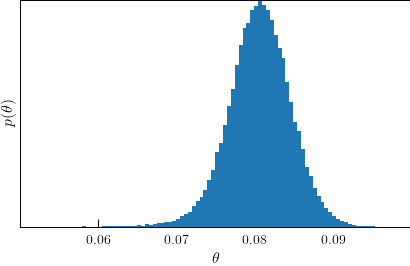

In [63]:
test = sampler.chain[:,:,0].T

plt.hist(test.flatten(), 100)
plt.gca().set_yticks([])
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$");

print('Running MCMC...')
nmbr = 1000
a = time.time()
for i, result in enumerate(sampler.run_mcmc(pos, nmbr, rstate0=np.random.get_state())):
    if True:  # (i+1) % 100 == 0:
        print("{0:5.1%}".format(float(i) / nmbr))
print('Done!')
print((time.time() - a) / 60.0, 'mins')

## Autocorrelation time estimates converge with longer chains

In [33]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2*n)
    acf = np.fft.ifft(f * np.conjugate(f))[:len(x)].real
    acf /= 4*n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

# Following the suggestion from Goodman & Weare (2010)
def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0*np.cumsum(f)-1.0
    window = auto_window(taus, c)
    return taus[window]

def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0*np.cumsum(f)-1.0
    window = auto_window(taus, c)
    return taus[window]

In [52]:
N = np.exp(np.linspace(np.log(1e4), np.log(test.shape[1]), 100)).astype(int)
print (N)

[10000  9701  9412  9132  8859  8595  8339  8091  7849  7615  7388  7168
  6955  6747  6546  6351  6162  5978  5800  5627  5459  5296  5139  4985
  4837  4693  4553  4417  4285  4158  4034  3913  3797  3684  3574  3467
  3364  3264  3166  3072  2980  2891  2805  2722  2640  2562  2485  2411
  2339  2270  2202  2136  2073  2011  1951  1893  1836  1782  1728  1677
  1627  1578  1531  1486  1441  1398  1357  1316  1277  1239  1202  1166
  1131  1098  1065  1033  1002   972   943   915   888   862   836   811
   787   763   740   718   697   676   656   636   617   599   581   564
   547   531   515   499]


/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


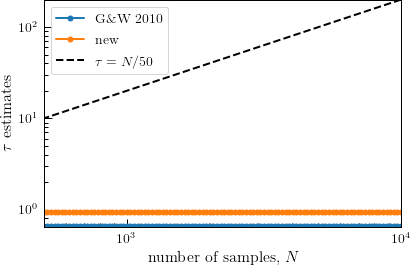

In [53]:
# Compute the estimators for a few different chain lengths
N = np.exp(np.linspace(np.log(1e4), np.log(test.shape[1]), 100)).astype(int)
gw2010 = np.empty(len(N))
new = np.empty(len(N))
for i, n in enumerate(N):
    gw2010[i] = autocorr_gw2010(test[:, :n])
    new[i] = autocorr_new(test[:, :n])

# Plot the comparisons
plt.loglog(N, gw2010, "o-", label="G\&W 2010")
plt.loglog(N, new, "o-", label="new")
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14);

In [66]:
emcee.autocorr.integrated_time(sampler.chain)

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/emcee/autocorr.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  acf = np.fft.ifft(f * np.conjugate(f), axis=axis)[m].real
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/emcee/autocorr.py:43: FutureWarning: Using a non-tuple sequence for multidimensional indexing

AutocorrError: The chain is too short to reliably estimate the autocorrelation time

## Save

In [10]:
np.save("{0:s}_samples{1:d}.npy".format('LeoP_autocorr_', nmbr), sampler.chain)

## Plots

In [11]:
burnin = int(0.8 * nmbr)

In [12]:
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
# Names of 8 parameters and input 'true' parameter values
prenams = ['y+', 'temperature', '$log(n_{e})$', 'c(H\\beta)', '$a_{H}$', '$a_{He}$', '$\\tau_{He}', '$log(\\xi)$'] # '$n_{HI}$']
#input_vals = np.array([0.08, 18000, 2, 0.1, 1.0, 1.0, 1.0, -2]) # Input parameters for fake spectra
input_vals = np.array([0.0837, 17200, 0, 0.1, 1.02, 0.45, 0.0, 0]) # Skillman et al. 2013's solved parameters for Leo P using eta, including HeI 5015


### Step vs Position in parameter space

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


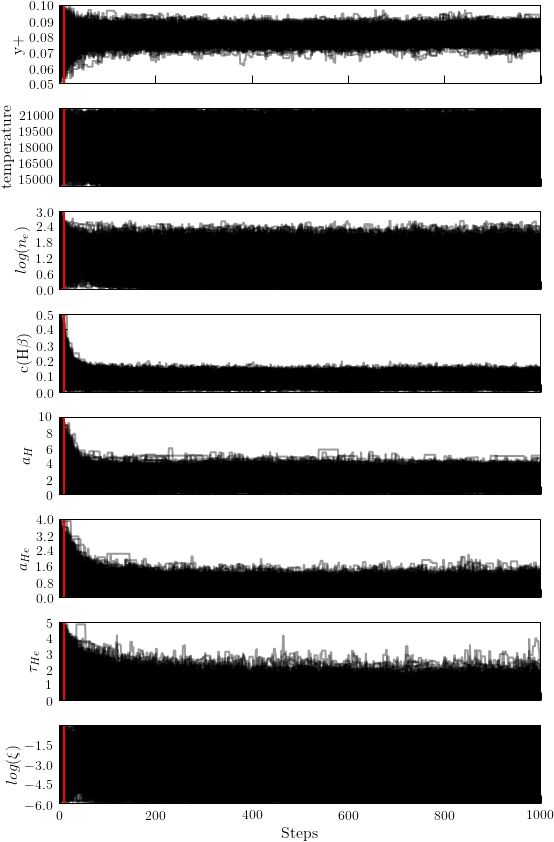

In [13]:
fig, axes = plt.subplots(ndim, 1, sharex=True, figsize=(8, 12))
for i in range(ndim):
    axes[i].plot(sampler.chain[:, :, i].T, color="k", alpha=0.4)
    axes[i].yaxis.set_major_locator(MaxNLocator(5))
    axes[i].axvline(10, color='red')
    axes[i].set_ylabel(prenams[i])
axes[7].set_xlabel('Steps')
fig.tight_layout(h_pad=0.0)
fig.savefig("{0:s}_samples{1:d}.pdf".format('LeoP_autocorr_timeevol', nmbr), overwrite=True)

### Corner

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


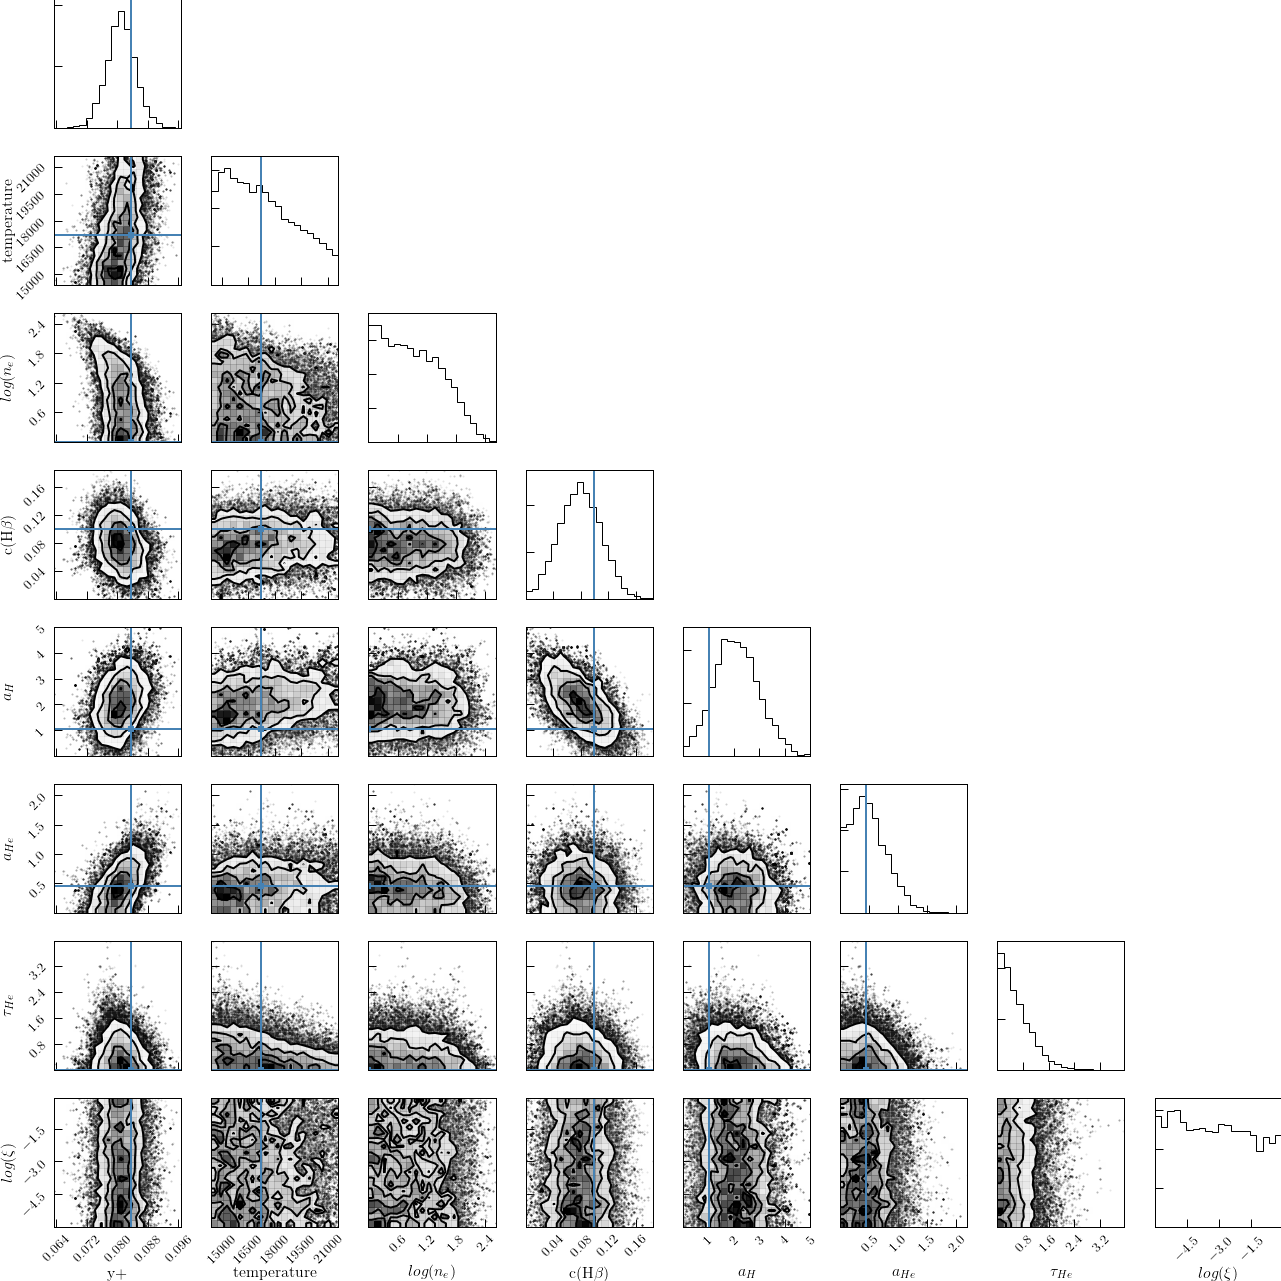

In [14]:
fig = corner.corner(samples, labels=prenams, truths=input_vals)
fig.savefig('{0:s}_samples{1:d}.pdf'.format('LeoP_autocorr_corner', nmbr), overwrite=True)

### Best values from MCMC

In [15]:
y_plus_mcmc, temp_mcmc, log_dens_mcmc, c_Hb_mcmc, a_H_mcmc, a_He_mcmc, tau_He_mcmc, log_xi_mcmc = map(lambda v: (v[1], v[2] - v[1], v[1] - v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))


In [16]:
print ('y+', y_plus_mcmc)
print ('T', temp_mcmc)
print ('log(n_e)', log_dens_mcmc)
print ('c(Hb)', c_Hb_mcmc)
print ('a_H', a_H_mcmc)
print ('a_He', a_He_mcmc)
print ('tau_He', tau_He_mcmc)
#print ('n_HI', n_HI_mcmc)
print ('log(xi)', log_xi_mcmc)

print ('\n Input parameter values:')
print (input_vals)

y+ (0.08099037492150124, 0.0036527446865873975, 0.0036323617107422157)
T (17054.427953080583, 2482.001725213766, 1813.9499302423465)
log(n_e) (0.8492702314585768, 0.7143847072917789, 0.6080863857578581)
c(Hb) (0.07838366232255568, 0.03022621454468473, 0.02972074353642678)
a_H (2.0643917302620696, 0.888617000082129, 0.8349579190847138)
a_He (0.45644556723548424, 0.35941659445466, 0.28910071107049573)
tau_He (0.4726555621321964, 0.5919306440300232, 0.33207042953015686)
log(xi) (-3.2166107509266366, 2.0533300310817895, 1.9271381400290108)

 Input parameter values:
[8.37e-02 1.72e+04 0.00e+00 1.00e-01 1.02e+00 4.50e-01 0.00e+00 0.00e+00]


In [20]:
chain = sampler.chain()[:, :, 0].T

plt.hist(chain.flatten(), 100)
plt.gca().set_yticks([])
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$");

TypeError: 'numpy.ndarray' object is not callable